### Import Libraries

In [17]:
# Bibliotecas RAPIDS (GPU)
from cuml.preprocessing import StandardScaler
from cuml.pipeline import Pipeline
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.metrics import accuracy_score
from cuml.metrics import confusion_matrix

# Bibliotecas Scikit-learn (CPU)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold 
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler # Necessário para o MLP na CPU/TF

# Bibliotecas de Utilidades
import cupy as cp  # cupy é o "numpy" do RAPIDS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

# Bibliotecas TensorFlow
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import gc

# Configuração para não travar a memória da GPU com o TF, permitindo rodar junto com o RAPIDS
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Audio Preprocessing

In [18]:
# 1. Carregar os dados oficiais
METADATA_DIR = '../fma_metadata' 
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')
features = utils.load(f'{METADATA_DIR}/features.csv')

# 2. Filtrar pelo dataset 'small'
small_mask = tracks[('set', 'subset')] == 'small'

X_all_pd = features.loc[small_mask] # Deixar como Pandas DataFrame
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')] # Deixar como Pandas Series
splits = tracks.loc[small_mask, ('set', 'split')]

y_all_labels_pd = y_all_labels_pd.astype(str)

print(f"Total de faixas 'fma_small': {X_all_pd.shape[0]}")
print(f"Total de features: {X_all_pd.shape[1]}")

# 3. EXTRAIR GRUPOS (ARTIST ID) - NOVO
groups_np = tracks.loc[small_mask, ('artist', 'id')].to_numpy()

# 4. Codificar os Gêneros (Labels) - Usando Sklearn
label_encoder = LabelEncoder()
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32) # Array Numpy

# 5. Converter X para Numpy (para o loop do sklearn)
X_all_np = X_all_pd.to_numpy()

Total de faixas 'fma_small': 8000
Total de features: 518


Calculando matriz de correlação...


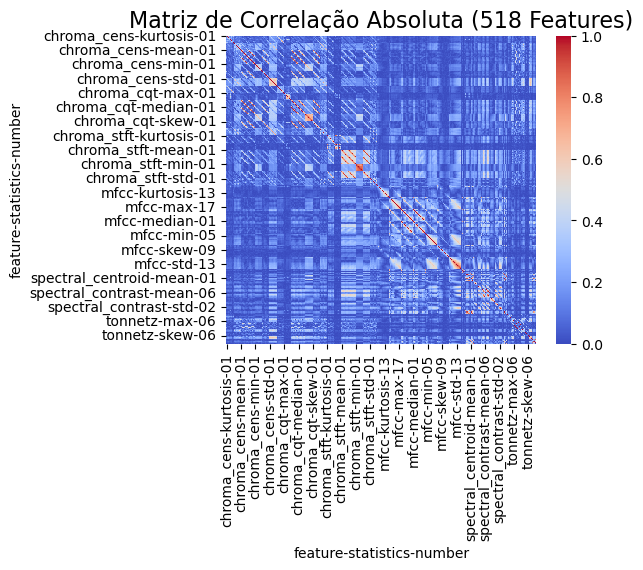


Número de features com correlação > 0.95: 77
Algumas features sugeridas para remoção: [('chroma_cens', 'median', '01'), ('chroma_cens', 'median', '02'), ('chroma_cens', 'median', '03'), ('chroma_cens', 'median', '04'), ('chroma_cens', 'median', '05'), ('chroma_cens', 'median', '06'), ('chroma_cens', 'median', '07'), ('chroma_cens', 'median', '08'), ('chroma_cens', 'median', '09'), ('chroma_cens', 'median', '10')]
Shape original: (8000, 518)
Shape após remoção: (8000, 441)


In [19]:
# --- ANÁLISE DE CORRELAÇÃO ---

# 1. Calcular a matriz de correlação (usando Pandas na CPU, pois é rápido para 8000 linhas)
print("Calculando matriz de correlação...")
corr_matrix = X_all_pd.corr().abs()

# 2. Plotar o Heatmap (Visualização)
# Como são 518 features, plotar tudo com anotações é ilegível.
# Vamos plotar o mapa de calor geral para ver padrões de redundância.
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Matriz de Correlação Absoluta (518 Features)', fontsize=16)
plt.show()

# 3. Identificar features altamente correlacionadas para remoção (Feature Selection)
# Se duas features têm correlação > 0.95, elas trazem quase a mesma informação.
# Podemos remover uma delas para reduzir ruído e custo computacional.

threshold = 0.95
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"\nNúmero de features com correlação > {threshold}: {len(to_drop)}")
print("Algumas features sugeridas para remoção:", to_drop[:10])

# OPCIONAL: Se quiser aplicar a remoção imediatamente para testar o impacto na acurácia:
#X_all_pd_reduced = X_all_pd.drop(columns=to_drop)
#X_all_np = X_all_pd_reduced.to_numpy()
#print(f"Novo shape de X após remoção de correlações: {X_all_np.shape}")

# --- APLICAÇÃO DA REMOÇÃO DE FEATURES ---

# Criar uma lista das colunas para remover
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Remover do dataset original (Pandas)
X_all_pd_reduced = X_all_pd.drop(columns=to_drop)

print(f"Shape original: {X_all_pd.shape}")
print(f"Shape após remoção: {X_all_pd_reduced.shape}")

X_all_np = X_all_pd_reduced.to_numpy()

# Casting para float32 para economizar VRAM e garantir compatibilidade
X_data = X_all_np.astype(np.float32)
y_data = y_all_encoded_np.astype(np.int32)
groups = groups_np

# Definir número de classes
num_classes = len(np.unique(y_data))

### Treino dos Modelos

In [20]:
def build_reference_mlp(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # Arquitetura baseada no classificador de voz enviado
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4), # Dropout ajuda a evitar overfitting
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        
        # ADAPTAÇÃO: Saída para 8 gêneros (Softmax) em vez de binário (Sigmoid)
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # Sparse pois seus labels são inteiros (0, 1, 2...)
        metrics=['accuracy']
    )
    return model

Iniciando treinamento com 10 folds...
Shape dos dados: (8000, 441)

Iniciando CV 10-Fold para KNN (GPU)...

Iniciando CV 10-Fold para SVM (GPU)...

Iniciando CV 10-Fold para Random Forest (GPU)...

Iniciando CV 10-Fold para XGBoost (GPU)...

Iniciando CV 10-Fold para MLP (Keras)...

--- Avaliação Concluída ---

========= KNN (GPU) =========
Acurácia       : Média 0.3475 | Std 0.0275
Precisão       : Média 0.3459 | Std 0.0264
Recall         : Média 0.3511 | Std 0.0259
F1-Score       : Média 0.3303 | Std 0.0272

========= SVM (GPU) =========
Acurácia       : Média 0.5436 | Std 0.0408
Precisão       : Média 0.5307 | Std 0.0408
Recall         : Média 0.5432 | Std 0.0383
F1-Score       : Média 0.5280 | Std 0.0400

========= Random Forest (GPU) =========
Acurácia       : Média 0.4924 | Std 0.0380
Precisão       : Média 0.4765 | Std 0.0339
Recall         : Média 0.4992 | Std 0.0323
F1-Score       : Média 0.4727 | Std 0.0340

========= XGBoost (GPU) =========
Acurácia       : Média 0.5441 | St

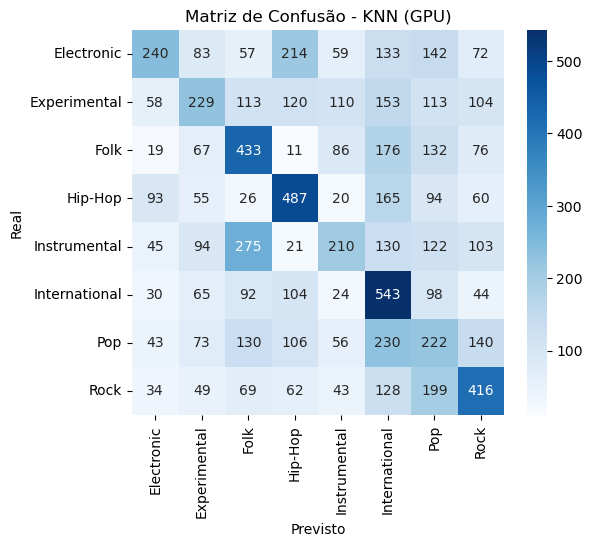

--- SVM (GPU) ---


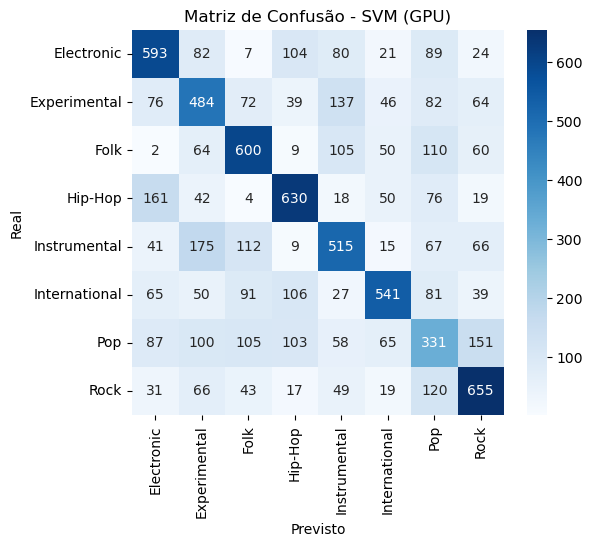

--- Random Forest (GPU) ---


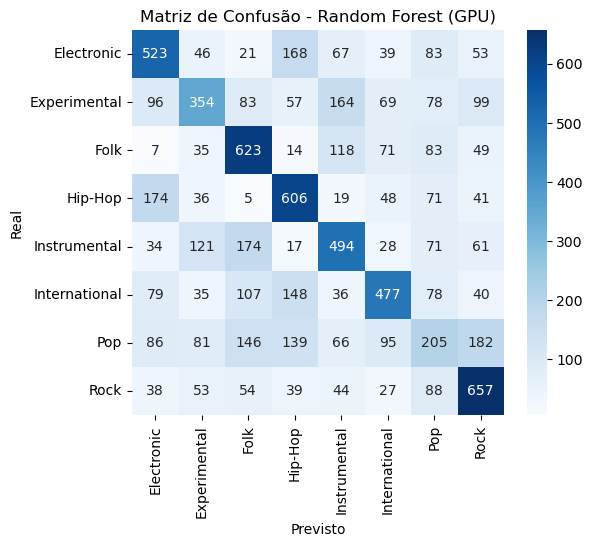

--- XGBoost (GPU) ---


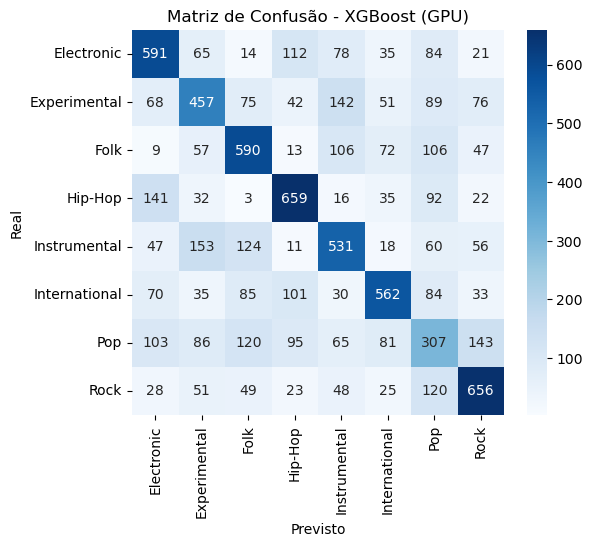

--- MLP (Keras) ---


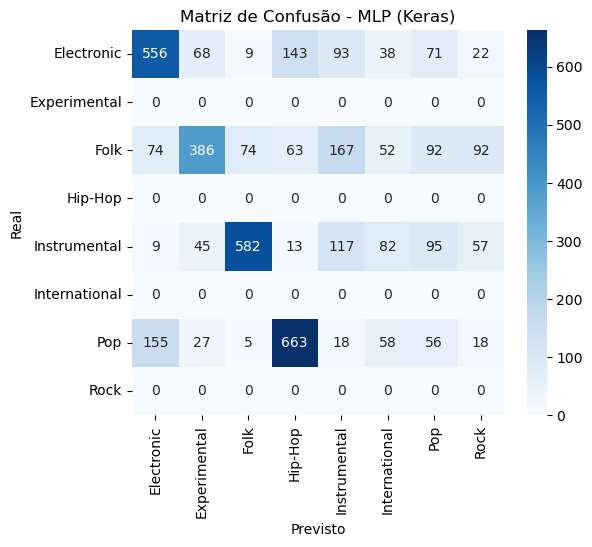

In [21]:
def calculate_metrics_from_confusion_matrix(cm):
    """
    Calcula Precisão, Recall e F1 (macro) a partir de uma matriz de confusão cupy.
    """
    # Evitar divisão por zero (adiciona um valor muito pequeno onde a soma é 0)
    epsilon = 1e-9
    
    # 1. True Positives (TP): A diagonal
    tp = cp.diag(cm)
    
    # 2. False Positives (FP): Soma da coluna - TP
    fp = cp.sum(cm, axis=0) - tp
    
    # 3. False Negatives (FN): Soma da linha - TP
    fn = cp.sum(cm, axis=1) - tp
    
    # 4. Calcular métricas por classe
    precision_per_class = tp / (tp + fp + epsilon)
    recall_per_class = tp / (tp + fn + epsilon)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + epsilon)
    
    # 5. Calcular a média "macro"
    macro_precision = cp.mean(precision_per_class)
    macro_recall = cp.mean(recall_per_class)
    macro_f1 = cp.mean(f1_per_class)
    
    return macro_precision, macro_recall, macro_f1

# 4. Definir a Estratégia de CV
# Usar StratifiedKFold é ideal para classificação, pois mantém
# a proporção de classes em cada fold (o fma_small é balanceado,
# mas esta é uma boa prática).
n_splits = 10
kf = GroupKFold(n_splits=n_splits)

# 5. Criar Pipelines para os Modelos
# Isso garante que o StandardScaler seja "fitado" apenas nos dados
# de treino de cada fold, e depois "transforma" os dados de treino e teste.

## Pipeline para KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=1)) # Ajuste os hiperparâmetros aqui
])

## Pipeline para SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale')) # Ajuste os hiperparâmetros
])

pipe_rf = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20))
])

# 2. XGBoost (Portado do v2 para o contexto do v1)
model_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    tree_method='hist',     # Otimizado para GPU
    device="cuda",          # Usa a RTX 3060
    random_state=42,
    objective='multi:softmax',
    num_class=num_classes 
)

# Dicionário de modelos
models = {
    "KNN (GPU)": pipe_knn,
    "SVM (GPU)": pipe_svm,
    "Random Forest (GPU)": pipe_rf,
    "XGBoost (GPU)": model_xgb,
    "MLP (Keras)": "keras_placeholder" # Marcador para lógica especial
}

# Dicionário para guardar os scores de CADA métrica para cada modelo
# Ex: cv_scores['KNN']['Accuracy'] = [0.5, 0.52, ...]
cv_scores = {}

# Dicionário para guardar as previsões e rótulos de todos os folds,
# para a matriz de confusão final
out_of_fold_preds = {}

print(f"Iniciando treinamento com {n_splits} folds...")
print(f"Shape dos dados: {X_all_np.shape}")

for model_name, model in models.items():
    print(f"\nIniciando CV 10-Fold para {model_name}...")
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []
    
    all_y_true = []
    all_y_pred = []

    # Loop de Folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_all_np, y_all_encoded_np, groups=groups_np)):
        # Dados em Numpy (CPU) inicialmente
        X_train, X_test = X_all_np[train_idx], X_all_np[test_idx]
        y_train, y_test = y_all_encoded_np[train_idx], y_all_encoded_np[test_idx]
        
        y_pred_fold = None # Variável para guardar as previsões deste fold

        # --- LÓGICA ESPECÍFICA POR TIPO DE MODELO ---
        
        # 1. MLP (TensorFlow/Keras)
        if model_name == "MLP (Keras)":
            # Scaling na CPU para o TF
            scaler = SklearnStandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Build & Train
            keras_model = build_reference_mlp(X_train.shape[1], num_classes)
            es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
            
            keras_model.fit(
                X_train_scaled, y_train,
                epochs=50, # Pode aumentar se tiver paciência
                batch_size=32,
                validation_split=0.1,
                callbacks=[es],
                verbose=0
            )
            
            # Predict
            y_probs = keras_model.predict(X_test_scaled, verbose=0)
            y_pred_fold = np.argmax(y_probs, axis=1)
            
            # Limpeza Crítica para GPU 6GB
            tf.keras.backend.clear_session()
            del keras_model, X_train_scaled, X_test_scaled
            gc.collect()

        # 2. Modelos GPU
        elif "(GPU)" in model_name:
            # Converter para CuPy (GPU)
            X_train_cp = cp.array(X_train)
            X_test_cp = cp.array(X_test)
            y_train_cp = cp.array(y_train)
            
            model.fit(X_train_cp, y_train_cp)
            y_pred_cp = model.predict(X_test_cp)
            
            # Trazer de volta para CPU para métricas unificadas depois
            y_pred_fold = cp.asnumpy(y_pred_cp)
            
            # Limpeza
            del X_train_cp, X_test_cp, y_train_cp, y_pred_cp

        # --- MÉTICAS UNIFICADAS ---
        
        # Acurácia (cuml accuracy_score aceita numpy e devolve float ou array 0-d)
        acc = accuracy_score(y_test, y_pred_fold)
        fold_scores_acc.append(acc)
        
        # Matriz de Confusão (cuml confusion_matrix aceita numpy e retorna cupy ou numpy)
        # Garantimos que seja cupy para a função calculate_metrics
        cm_fold = confusion_matrix(y_test, y_pred_fold)
        
        macro_p, macro_r, macro_f1 = calculate_metrics_from_confusion_matrix(cm_fold)
        
        # Converter métricas scalarem de volta para CPU/float para armazenar na lista
        fold_scores_precision.append(float(macro_p))
        fold_scores_recall.append(float(macro_r))
        fold_scores_f1.append(float(macro_f1))
        
        # Acumular para Matriz Final
        all_y_true.append(y_test)
        all_y_pred.append(y_pred_fold)
    
    # Armazenar resultados do modelo
    cv_scores[model_name] = {
        'Acurácia': np.array(fold_scores_acc),
        'Precisão': np.array(fold_scores_precision),
        'Recall': np.array(fold_scores_recall),
        'F1-Score': np.array(fold_scores_f1)
    }
    
    out_of_fold_preds[model_name] = {
        'y_true': np.concatenate(all_y_true),
        'y_pred': np.concatenate(all_y_pred)
    }
    
    # Limpeza final do modelo
    gc.collect()
    cp.get_default_memory_pool().free_all_blocks()

print("\n--- Avaliação Concluída ---")

# 4. Exibição dos Resultados
for model_name, metrics in cv_scores.items():
    print(f"\n========= {model_name} =========")
    for metric_name, values in metrics.items():
        print(f"{metric_name:15}: Média {values.mean():.4f} | Std {values.std():.4f}")

# 5. Plot das Matrizes de Confusão
print("\n========= Matrizes de Confusão Agregadas =========")
class_names = label_encoder.classes_ # Nomes dos gêneros

for model_name, results in out_of_fold_preds.items():
    print(f"--- {model_name} ---")
    
    # Calcular CM total usando cuML
    cm_gpu = confusion_matrix(results['y_true'], results['y_pred'])
    cm_cpu = cp.asnumpy(cm_gpu) # Mover para CPU para o Seaborn
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.show()